## Demand Planning using _EXPERT_

In this notebook, we’ll walk you through how to tackle a common use case: demand forecasting for efficient, data-driven planning. We’ll take demand data from an ERP system, use *CHECK-IN* to transform raw data into time series, and then let _FORECAST_ make predictions for the next 18 months.


After downloading the dataset, we connect to the client using our _future_ username and password.

In [1]:
from futureexpert import (DataDefinition,
                          ExpertClient,
                          FileSpecification,
                          ForecastingConfig,
                          MethodSelectionConfig,
                          PreprocessingConfig,
                          ReportConfig,
                          TsCreationConfig)
import futureexpert.checkin as checkin

client = ExpertClient()

INFO:futureexpert.expert_client:Successfully logged in for group group-expert.


### *CHECK-IN* Configuration

Now, let’s use *CHECK-IN* to transform our data and upload the resulting time series to our database. We define the location of the CSV file and its specifications (`separator`, `decimal`). For our use case, we need to consider the following settings:
- The data contains some missing values, which are equivalent to 'no demand' observations. Therefore, we set the `missing_value_handler` to `setToZero`.
- Material `C011414576` is an article that is no longer sold but is still part of the dataset. We do not need any forecasts for this material, so we can set a corresponding `FilterSettings`.
- The columns CUSTOMER, REGION, and MATERIAL contain structural information about the data, so we define them as `GroupColumns`. For this use case, however, we only want to create forecasts at the material level, so we set that column as the `grouping_level` in the `TsCreationConfig`.

In [ ]:
actuals_version_id = client.check_in_time_series(raw_data_source='demo_demand_planning_data.csv',
                                                  file_specification=FileSpecification(delimiter=';', decimal='.'),
                                                  data_definition=DataDefinition(date_columns=checkin.DateColumn(name='DATE', format='%d.%m.%Y', name_new = 'Date'),
                                                                                 value_columns=[checkin.ValueColumn(name='DEMAND', name_new='Demand')],
                                                                                 group_columns=[checkin.GroupColumn(name="CUSTOMER", name_new='Customer'),
                                                                                                checkin.GroupColumn(name="MATERIAL", name_new="Material"),
                                                                                                checkin.GroupColumn(name="REGION", name_new="Region")]),
                                                  config_ts_creation=TsCreationConfig(time_granularity='monthly',
                                                                                      start_date="2007-10-01",
                                                                                      end_date="2024-06-01",
                                                                                      value_columns_to_save=['Demand'],
                                                                                      grouping_level=["Material"],
                                                                                      missing_value_handler="setToZero",
                                                                                      filter=[checkin.FilterSettings(type='exclusion', variable='Material', items=['C011414576'])]))

INFO:futureexpert.expert_client:Transforming input data...
INFO:futureexpert.expert_client:Creating time series using CHECK-IN...
INFO:futureexpert.expert_client:Finished time series creation.


### _FORECAST_ Configuration
After checking in our data we are good to perform the forecast update with _FORECAST_. We configure preprocessing, forecasting, and method selection for proper report setup:

**Preprocessing**

- To gain additional insights into our data, we enable the detection of outliers, changepoints, and quantization sizes. Quantization detection also influences forecast generation: forecasts will align with the detected quantization multiples.

**Forecasting**

- We set the `fc_horizon` to 18 months and ensure nonnegative forecasts by applying a `lower_bound` of 0. Any observation below 0 is treated as 0, and forecasts will never fall below this threshold.
- By setting `use_ensemble` to `True`, we allow forecasts to be generated via a linear combination of well-performing methods. This ensemble, however, must compete with individual models during method selection and is not guaranteed to provide the final forecast.
- Prediction intervals are enabled with a confidence level of 0.75 (75%), and forecasts are rounded to integers, as demand is measured in whole units.

**Method Selection**

- Forecasting methods are chosen based on 18 backtesting iterations, with models being refitted for each round. During backtesting, we prioritize forecast steps three and four (`step_weights`: 100%), while steps five and contribute only 50% to the scoring. Steps before three and beyond six are excluded from the selection process.
- Additional accuracy metrics, such as mean error and mean absolute error, offer deeper insights into model performance but do not affect selection. The default metrics for model evaluation are mean squared error and periods in stock (for sporadic time series).

Additionally, we use a `max_ts_len` of 72 instead of the default 86 for monthly data, which means that for every time series, only a the last 72 observations is used by _FORECAST_. This increases performance a bit while having little impact on the quality of the results.

In [ ]:
import time
fc_report_config = ReportConfig(
    title='Monthly Demand Forecast on Material Level',
    preprocessing=PreprocessingConfig(remove_leading_zeros=True,
                                      detect_outliers=True,
                                      replace_outliers=True,
                                      detect_changepoints=True,
                                      detect_quantization=True),
    forecasting=ForecastingConfig(fc_horizon=18,
                                  lower_bound=0,
                                  use_ensemble=True,
                                  confidence_level=0.75,
                                  round_forecast_to_integer=True),
    method_selection=MethodSelectionConfig(number_iterations=18,
                                           refit=True,
                                           step_weights={3:1, 4:1, 5:0.5, 6:0.5},
                                           additional_accuracy_measures=['me', 'mae']),
    max_ts_len=72)

forecast_identifier = client.start_forecast(version=actuals_version_id, config=fc_report_config)
# Watch the current status of the forecasting report
while not (current_status := client.get_report_status(id=forecast_identifier)).is_finished:
    time.sleep(10)  # Wait between status requests

# Retrieve the results of the forecasting report
results = client.get_fc_results(id=forecast_identifier, include_backtesting=True, include_k_best_models=3)

INFO:futureexpert.expert_client:Preparing data for forecast...
INFO:futureexpert.expert_client:Finished data preparation for forecast.
INFO:futureexpert.expert_client:Started creating forecasting report with FORECAST...
INFO:futureexpert.expert_client:Finished report creation. Forecasts are running...


### Results Retrieval and Inspection of Results

Once forecasts are generated, we retrieve the results from the database using the identifier. For each material, we include the top three models and their backtesting results.

For each time series, we review an overview of key details, including the selected forecasting method, the best-performing model, the time series class, and other relevant characteristics.

In [4]:
from futureexpert.forecast import export_result_overview_to_pandas
export_result_overview_to_pandas(results)

,name,Material,model,cov,cov_lag,season_length,ts_class,quantization,trend,recent_trend,missing_values_count,outliers_count
0,Demand-C048529686,C048529686,MedianAS,NaN,NaN,[12],smooth,6.0,False,False,NaN,NaN
1,Demand-C026568362,C026568362,Glmnet(l1_ratio=1.0),NaN,NaN,[12],smooth,6.0,False,False,NaN,NaN
2,Demand-C042056164,C042056164,TBATS,NaN,NaN,[6],smooth,12.0,False,True,NaN,NaN
3,Demand-C011414575,C011414575,Ensemble,NaN,NaN,[1],smooth,78.0,False,True,NaN,NaN
4,Demand-C005824274,C005824274,MedianPattern,NaN,NaN,[12],intermittent,12.0,False,False,NaN,NaN
5,Demand-C023019522,C023019522,InterpolID,NaN,NaN,[12],intermittent,6.0,False,True,NaN,NaN
6,Demand-C048097345,C048097345,TBATS,NaN,NaN,[12],smooth,6.0,False,True,NaN,NaN
7,Demand-C018904994,C018904994,SVM,NaN,NaN,[3],lumpy,6.0,False,True,NaN,NaN
8,Demand-C013391652,C013391652,InterpolID,NaN,NaN,[3],intermittent,6.0,False,False,NaN,NaN
9,Demand-C010825983,C010825983,SVM,NaN,NaN,[6],lumpy,24.0,False,True,NaN,NaN


Now we take a look at the visualized forecasts. We limit the actuals to the last 6 years by setting `plot_last_x_data_points_only=72` to match the data we used for the analyses and focus only on the best model by specifying the rank list as `[1]`. Additionally, we analyze outliers and changepoints, including time windows with sparse observations. This information helps us gain deeper insights into the data and forecasts, allowing us to make the best possible decisions.

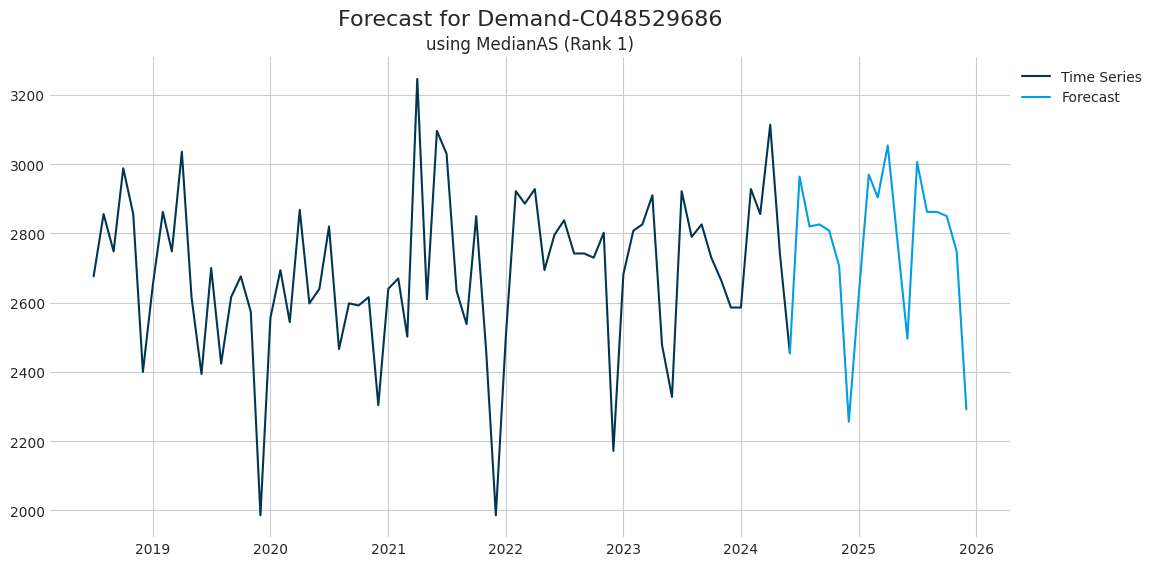

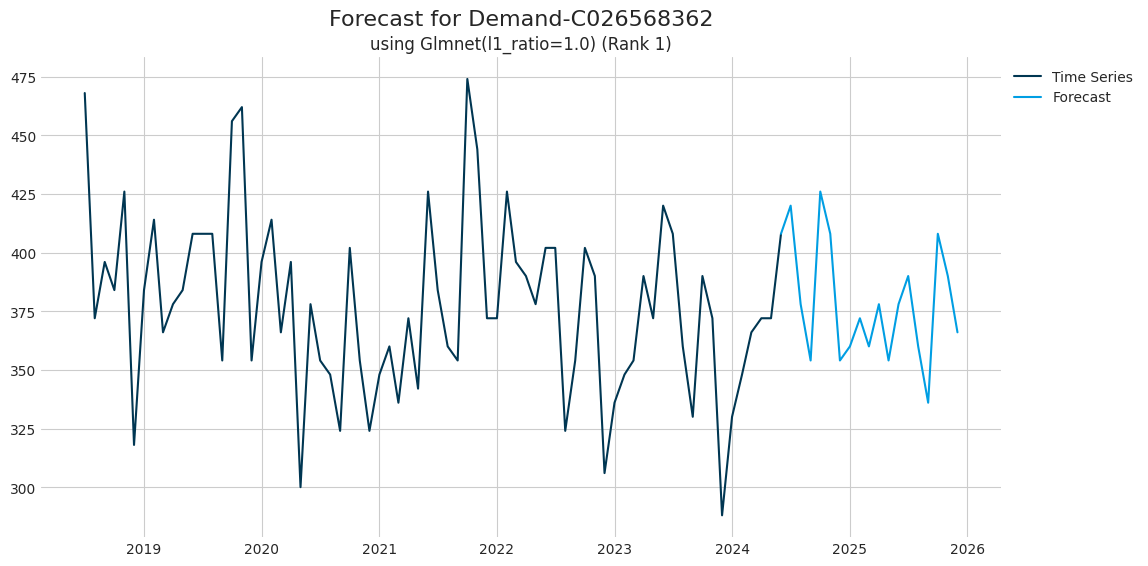

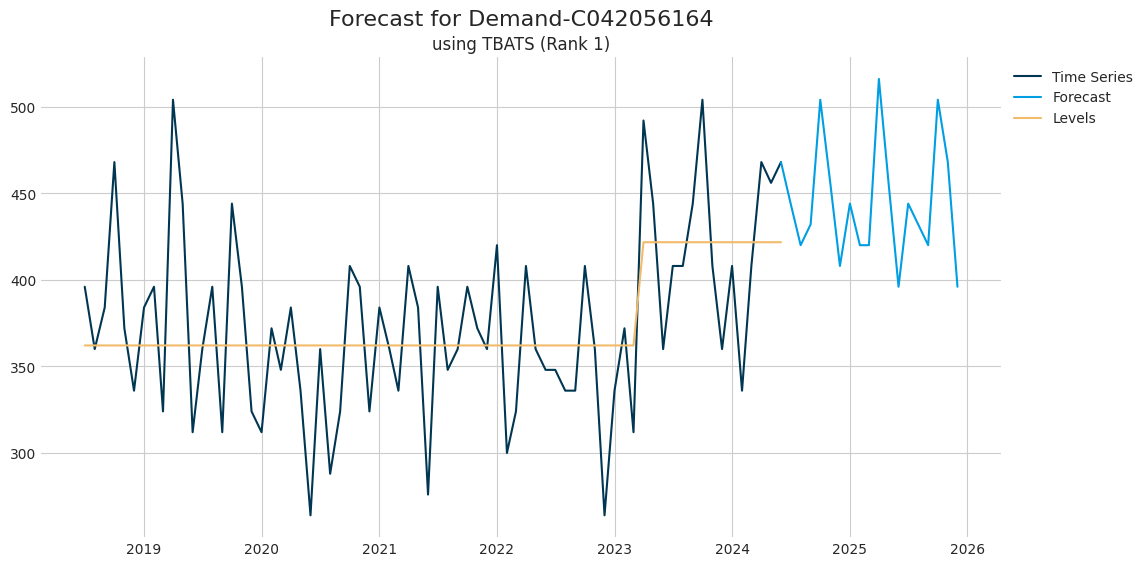

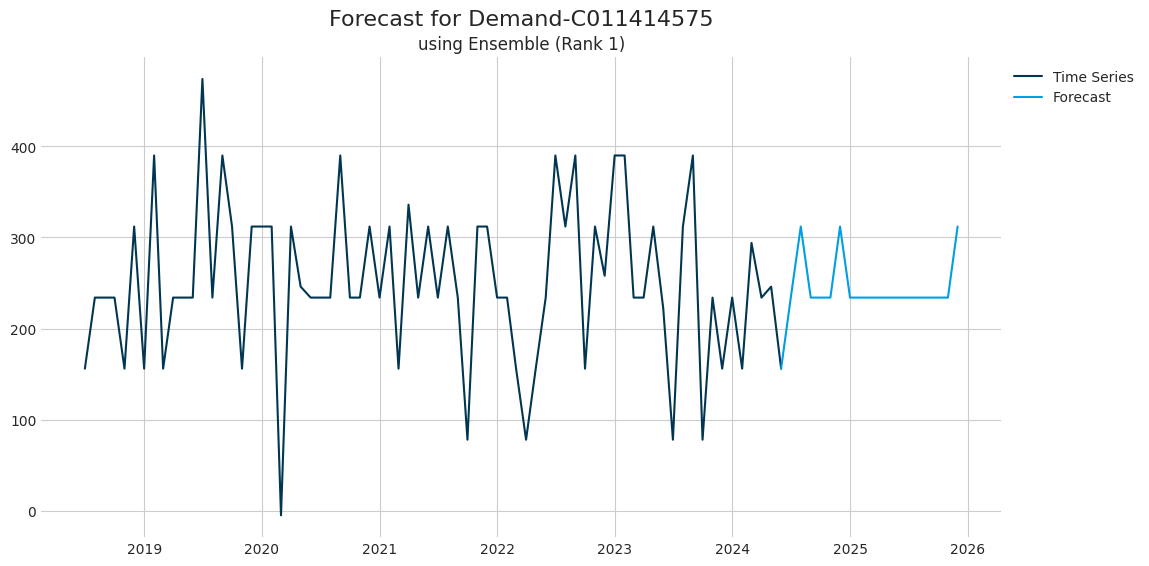

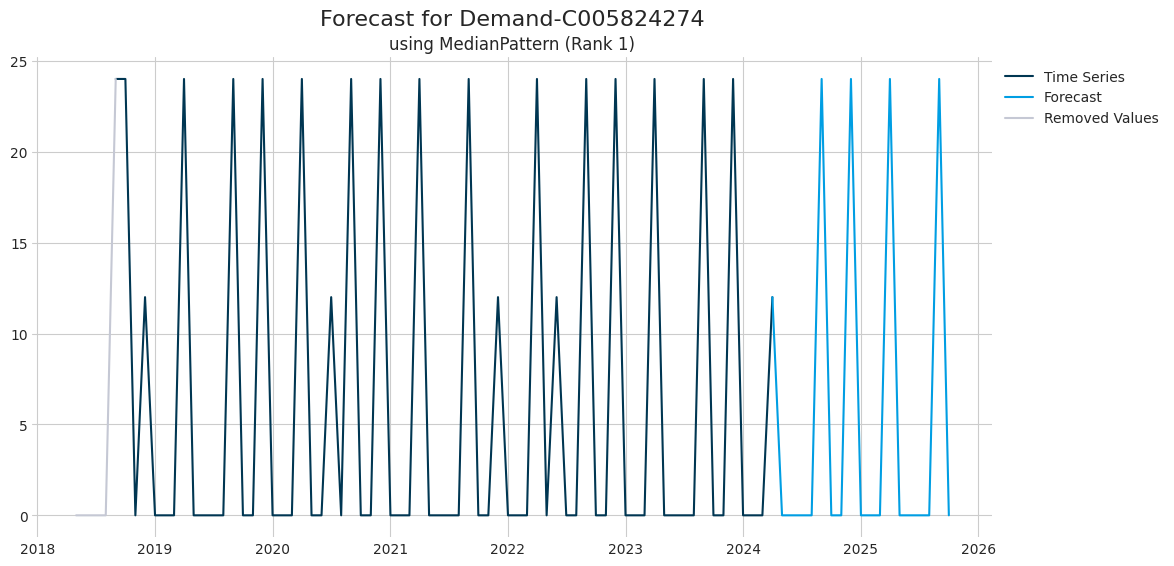

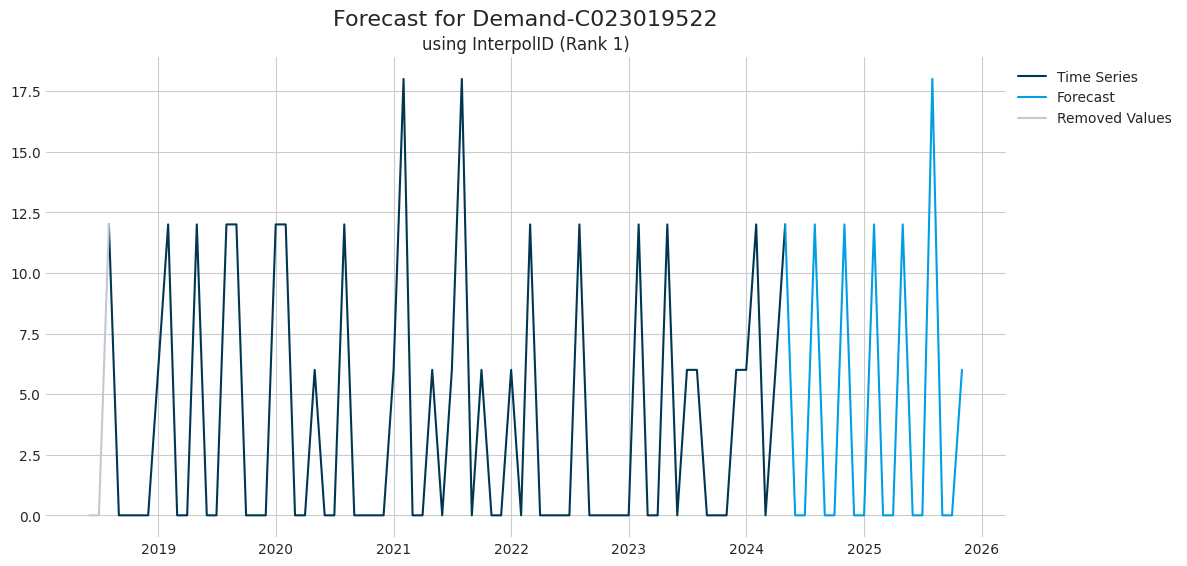

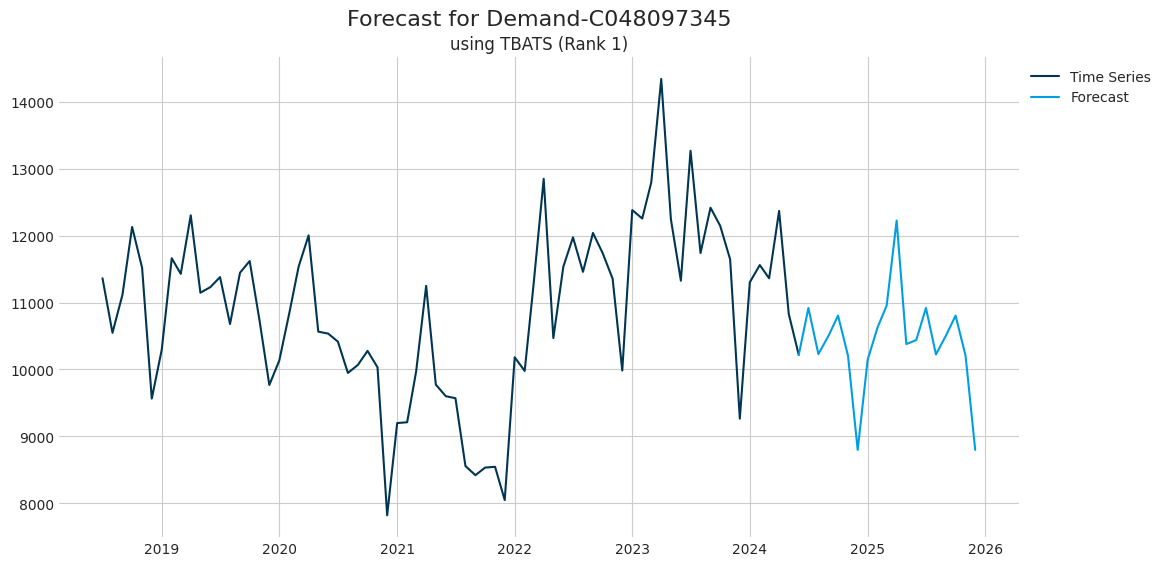

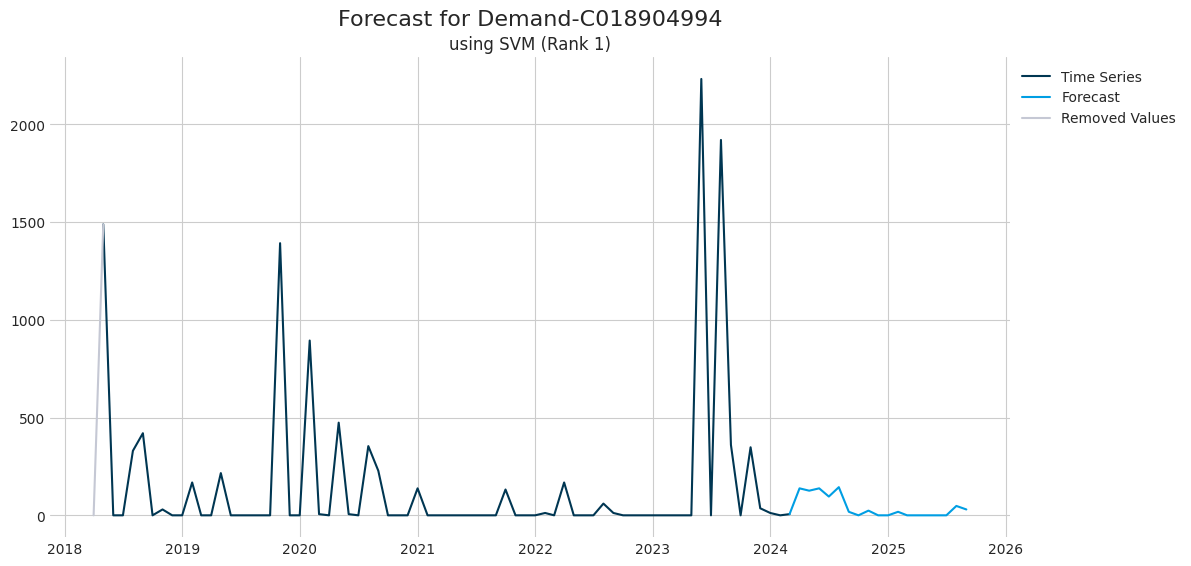

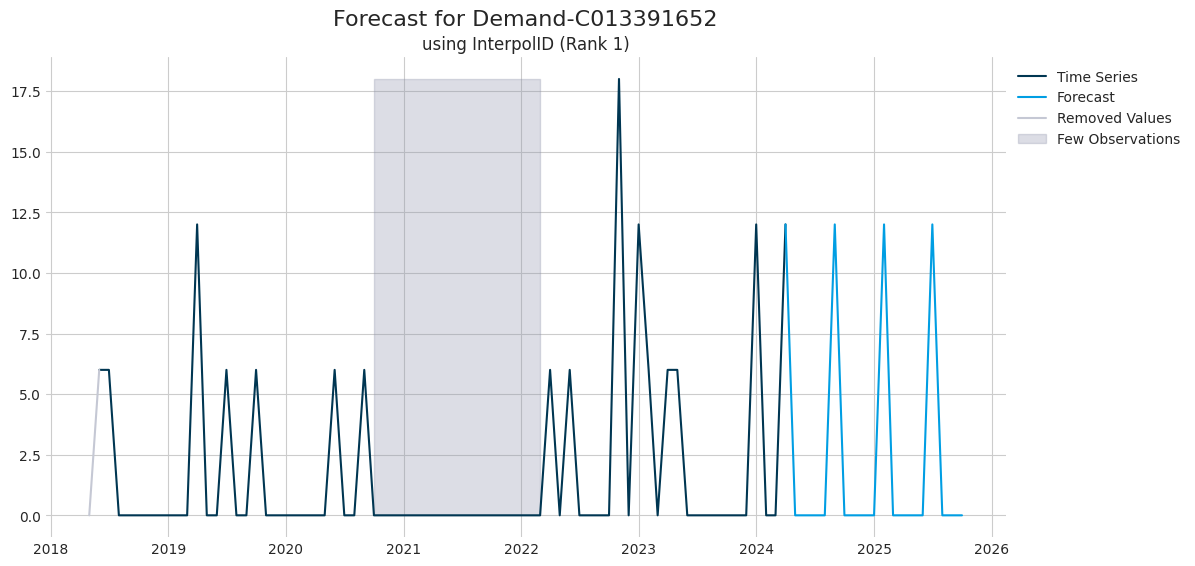

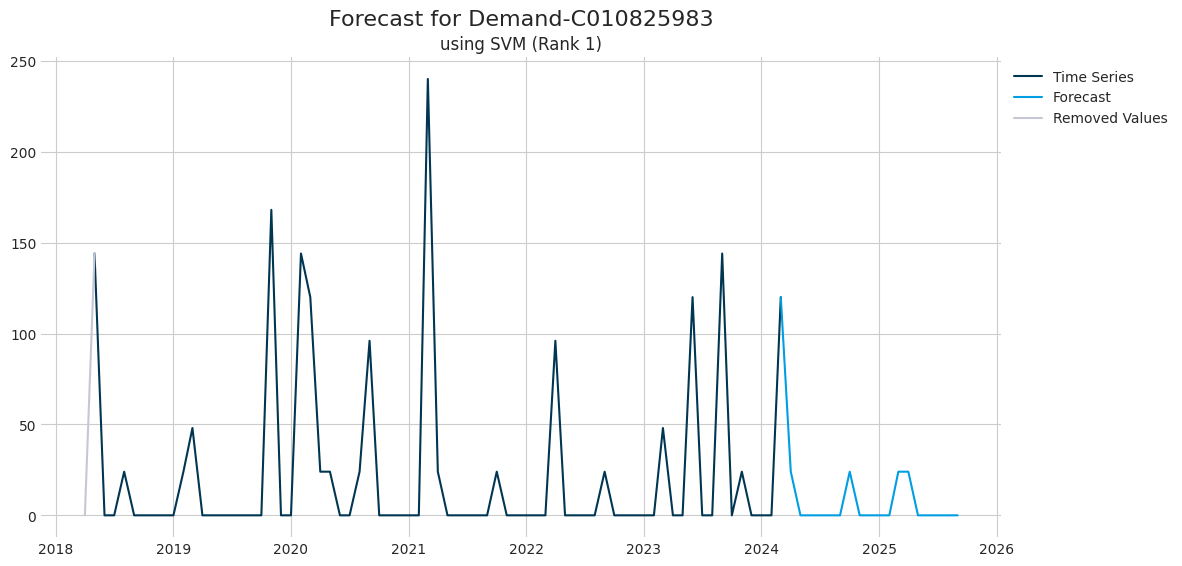

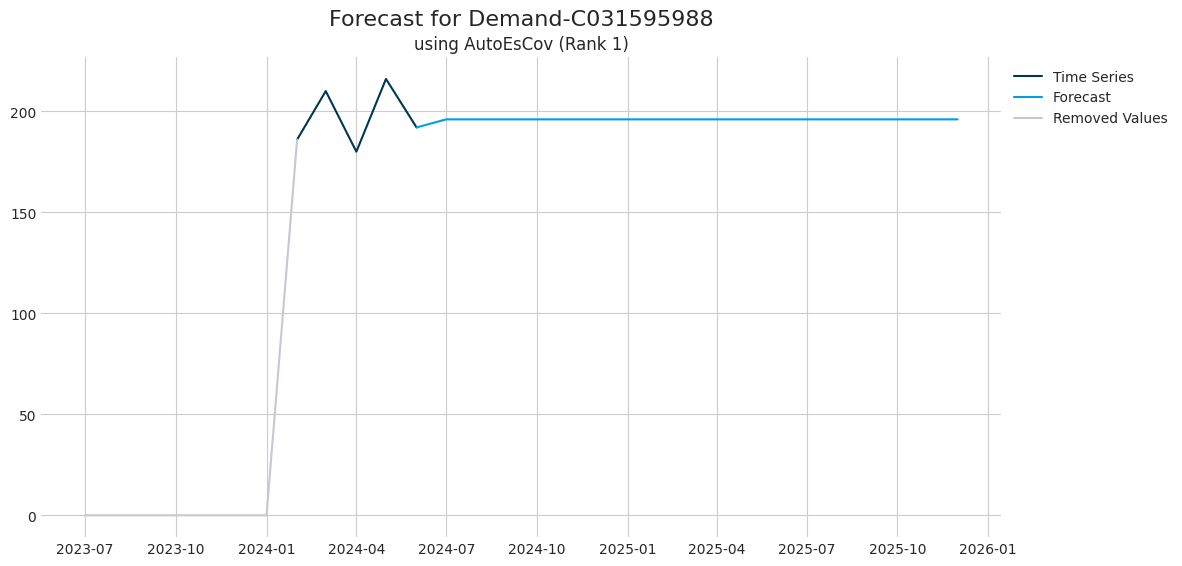

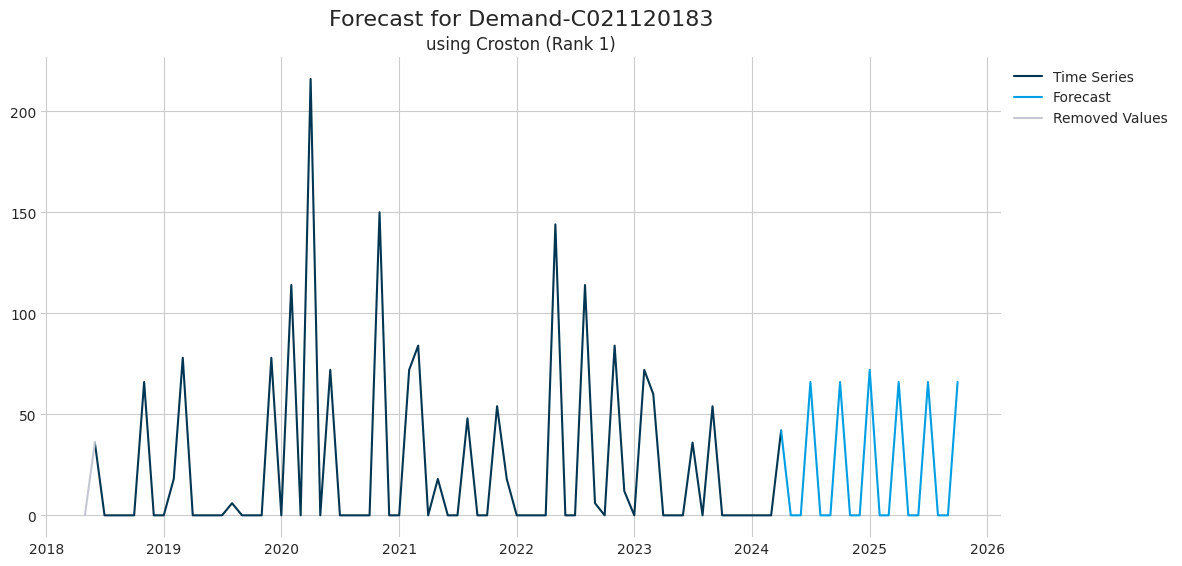

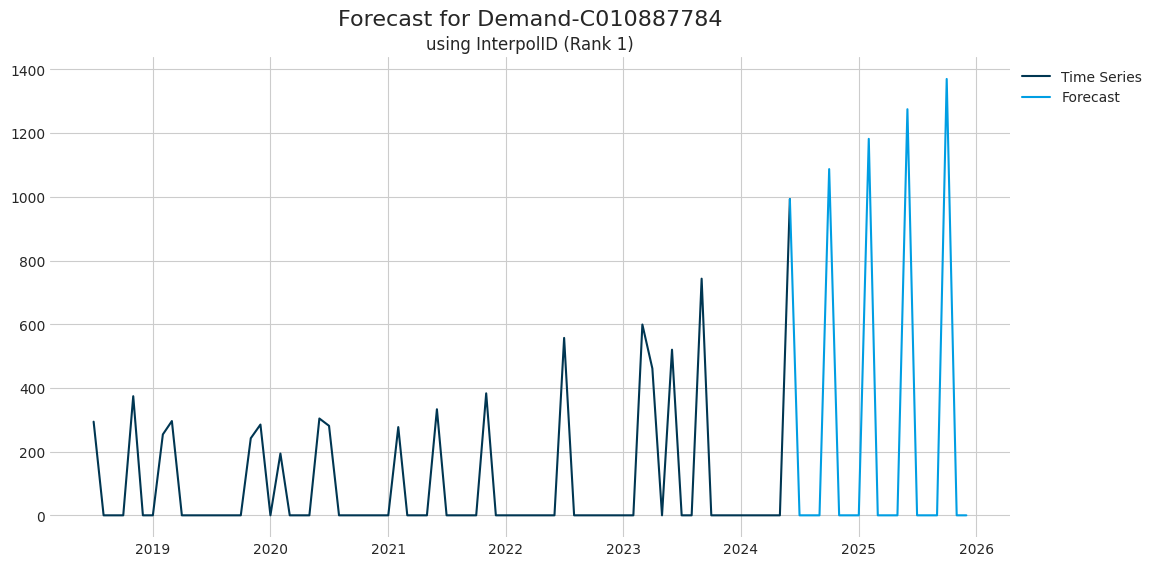

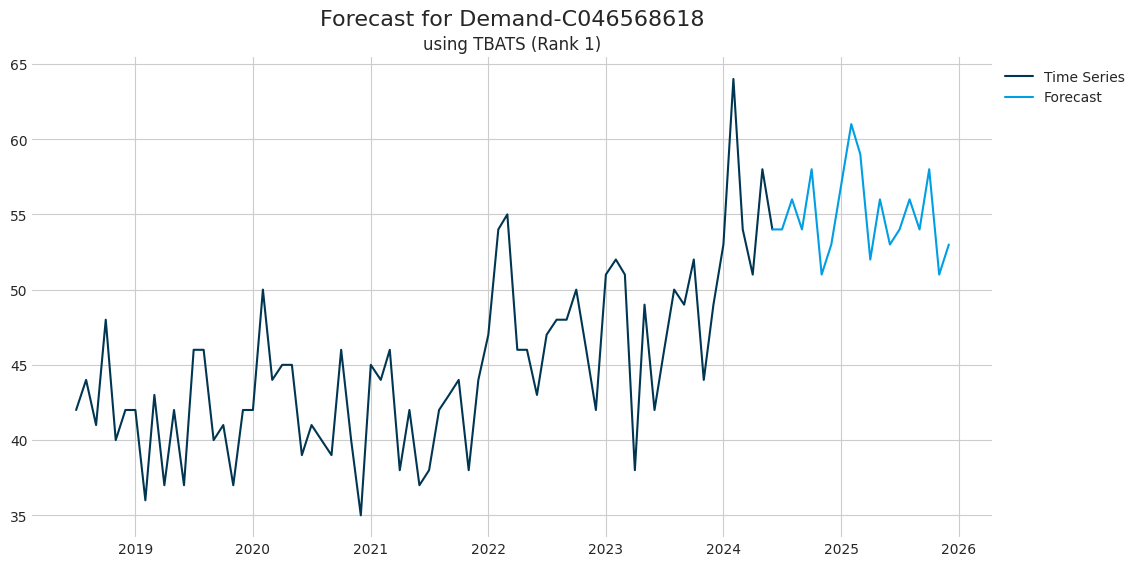

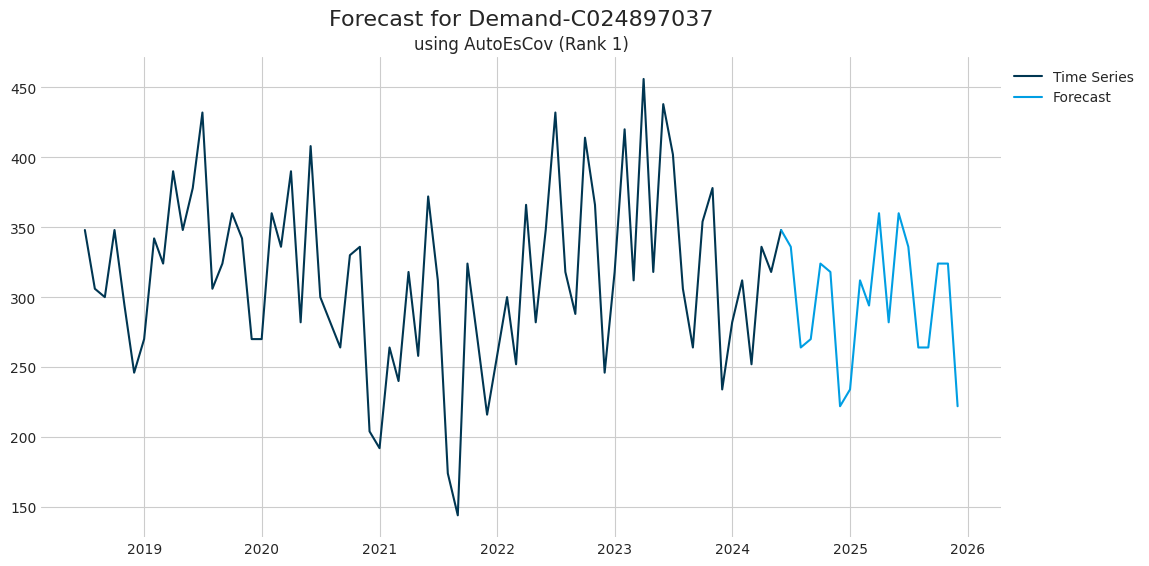

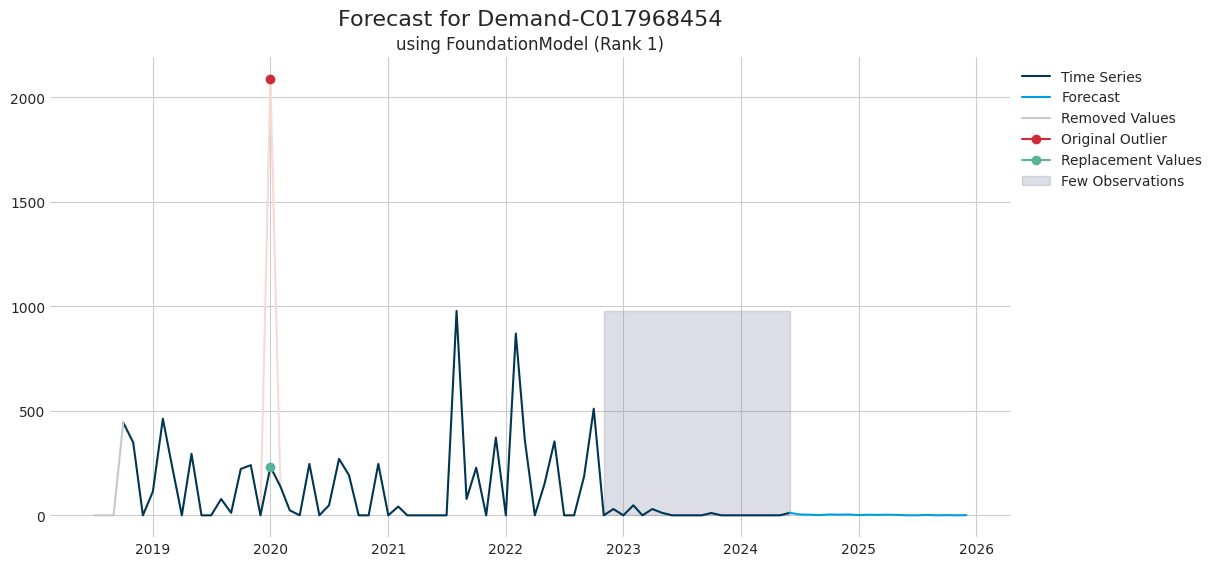

In [5]:
from futureexpert import plot
for ts in results:
    plot.plot_forecast(ts, plot_last_x_data_points_only=72, ranks=[1], plot_prediction_intervals=False,
                       plot_outliers=True, plot_change_points=True)
